In [1]:
import numpy as np
import sympy
from sympy import Expr, Eq, latex, plot_implicit, tan, cot
from sympy.core import S, pi, sympify
from sympy.core.logic import fuzzy_bool
from sympy.core.numbers import Rational, oo
from sympy.core.compatibility import ordered
from sympy.core.symbol import Dummy, _uniquely_named_symbol, _symbol
from sympy.simplify import simplify, trigsimp
from sympy.functions.elementary.miscellaneous import sqrt, Max
from sympy.functions.elementary.trigonometric import cos, sin, cot, tan
from sympy.functions.special.elliptic_integrals import elliptic_e
from sympy.geometry.exceptions import GeometryError
from sympy.geometry.line import Ray2D, Segment2D, Line2D, LinearEntity3D
from sympy.polys import DomainError, Poly, PolynomialError
from sympy.polys.polyutils import _not_a_coeff, _nsort
from sympy.solvers import solve
from sympy.solvers.solveset import linear_coeffs
from sympy.utilities.misc import filldedent, func_name
from sympy.geometry.entity import GeometryEntity, GeometrySet
from sympy.geometry.point import Point, Point2D, Point3D
from sympy.geometry.line import Line, Segment
from sympy.geometry.util import idiff
import matplotlib.pyplot as plt
%matplotlib inline

# Занятие 15
# Алгебра
## Кривые второго порядка на плоскости: гипербола

In [2]:
class Hyperbola(GeometrySet):
    """
     Attributes
    ==========
    center
    hradius
    vradius
    eccentricity
    periapsis
    focus_distance
    foci
    ==========
    конструктор __new__
    скопирован из Эллипса,
    изменена формула для  hradius и vradius через эсцентриситет
    """
    def __new__(
        cls, center=None, hradius=None, vradius=None, eccentricity=None, **kwargs):
        hradius = sympify(hradius)
        vradius = sympify(vradius)

        eccentricity = sympify(eccentricity)

        if center is None:
            center = Point(0, 0)
        else:
            center = Point(center, dim=2)

        if len(center) != 2:
            raise ValueError('The center of "{0}" must be a two dimensional point'.format(cls))

        if len(list(filter(lambda x: x is not None, (hradius, vradius, eccentricity)))) != 2:
            raise ValueError(filldedent('''
                Exactly two arguments of "hradius", "vradius", and
                "eccentricity" must not be None.'''))

        if eccentricity is not None:
            if hradius is None:
                hradius = vradius/sqrt( eccentricity**2 - 1)
            elif vradius is None:
                vradius = hradius*sqrt( eccentricity**2 - 1)

        if hradius == 0:
            return "Line"
        if vradius == 0:
            return "Rays"
        return GeometryEntity.__new__(cls, center, hradius, vradius, **kwargs)
    
    @property
    def ambient_dimension(self):
        return 2
    
    @property
    def center(self):
        return self.args[0]

    @property
    def hradius(self):
        return self.args[1]
    
    @property
    def vradius(self):
        return self.args[2]
    @property
    def focus_distance(self):
        return sqrt(self.hradius**2 + self.vradius**2)
    
    @property
    def eccentricity(self):
        """The eccentricity of the ellipse."""
        return self.focus_distance/self.hradius
    
    @property
    def periapsis(self):
        """The apoapsis of the hyperbola.
        The smallest distance between the focus and the contour."""
        return self.focus_distance-self.hradius
    @property
    def foci(self):
        return (self.center + Point(-self.focus_distance, 0), self.center + Point(self.focus_distance, 0))
    
    @property
    def major(self):
        return self.hradius
    
    @property
    def minor(self):
        return self.vradius
    
    def equation(self, x='x', y='y', _slope=None, equation=False):
        """
        Returns the equation of a hyperbola aligned with the x and y axes;
        when slope is given, the equation returned corresponds to a hyperbola 
        with a major axis having that slope.
        Parameters
        ==========
        x : str, optional
            Label for the x-axis. Default value is 'x'.
        y : str, optional
            Label for the y-axis. Default value is 'y'.
        _slope : Expr, optional
                The slope of the major axis. Ignored when 'None'.
        Returns
        =======
        equation : sympy expression   """

        x = _symbol(x, real=True)
        y = _symbol(y, real=True)

        dx = x - self.center.x
        dy = y - self.center.y

        if _slope is not None:
            L = (dy - _slope*dx)**2
            l = (_slope*dy + dx)**2
            h = 1 + _slope**2
            a = h*self.major**2
            b = h*self.minor**2
            res= l/a - L/b 

        else:
            t1 = (dx/self.hradius)**2
            t2 = (dy/self.vradius)**2
            res = t1 - t2 
        if not equation:
            return res - 1
        else:
            return Eq(res, 1)       

    def directrix(self, x='x', equation=False):
      x = _symbol(x, real=True)
      if not equation:
        return (self.center.x + self.hradius**2 / self.focus_distance, self.center.x - self.hradius**2 / self.focus_distance)
      else:
        return (Eq(x, self.center.x + self.hradius**2 / self.focus_distance), Eq(x, self.center.x - self.hradius**2 / self.focus_distance))

    def asymptote(self, x='x', y='y', equation=False):
      x = _symbol(x, real=True)
      y = _symbol(y, real=True)
      if not equation:
        return (self.center.y + (self.vradius / self.hradius)*(x - self.center.x), self.center.y - (self.vradius / self.hradius)*(x - self.center.x))
      else:
        return (Eq(y, self.center.y + (self.vradius / self.hradius)*(x - self.center.x)), Eq(y, self.center.y - (self.vradius / self.hradius)*(x - self.center.x)))

# Занятие 15
# Алгебра
### Задание 1.
Построить гиперболу с центром в точке А(1, 2), полуосями 12 и 5. Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis и уравнение гиперболы.

In [4]:
 Hyp1 = Hyperbola(Point(1, 2), hradius=12, vradius=5)

 props = {'eccentricity': Hyp1.eccentricity, 'periapsis': Hyp1.periapsis,
 'focus_distance': Hyp1.focus_distance, 'foci': Hyp1.foci, 'equation': Hyp1.equation()}
for key in props.keys():
  display(key, props[key])

'eccentricity'

13/12

'periapsis'

1

'focus_distance'

13

'foci'

(Point2D(-12, 2), Point2D(14, 2))

'equation'

(x/12 - 1/12)**2 - (y/5 - 2/5)**2 - 1

### Задание 2.
Добавить в описание класса гипербол методы 

asymptote(self, x='x', y='y', equation=False)

directrix(self, x='x', equation=False)

Для гиперболы Задания 1 вывести на экран уравнения асимптот и директрис.

In [9]:
display(*Hyp1.asymptote(equation = True))
display('--------------')
display(*Hyp1.directrix(equation = True))

Eq(y, 5*x/12 + 19/12)

Eq(y, 29/12 - 5*x/12)

'--------------'

Eq(x, 157/13)

Eq(x, -131/13)

### Задание 3.
Вывести на экран уравнение гиперболы из задания 1 с поворотом на 30 градусов против часовой стрелки относительно ее центра.
Изобразить повернутую гиперболу с помощью plot_implicit.

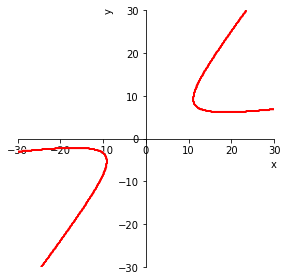

In [12]:
eq2 = Hyp1.equation(_slope=1/3**(S.Half), equation=True)

dict_free = {str(a): a for a in eq2.free_symbols}
p = plot_implicit(eq2, (dict_free['x'], -30, 30), (dict_free['y'], -30, 30),
 line_color='r', aspect_ratio=(1, 1), show=False, adaptive=False)

p.show()

## Уравнения директрис и асимптот при повороте на угол $\alpha$
Пусть  $a$ - горизонтальная полуось, $c$ - фокусное расстояние, $x_0$ - горизонтальная координата центра гиперболы, тогда уравнение директрис 
$$
x = x_0 \pm \frac{a^2}{c}
$$
При повороте на угол $\alpha$ получается уравнение
$$
y = y_0 -{\rm ctg} \alpha(x - x_0) \pm \frac{a^2}{c}\sqrt{1 + {\rm ctg} \alpha}
$$
Уравнение асимптоты
$$
y = y_0 \pm \frac{b}{a}(x - x_0)
$$
При повороте на угол $\alpha$ получаются уравнения
\begin{align*}
y_1 = y_0 + k_1(x - x_0), \quad 
y_2 = y_0 + k_2(x - x_0), \\ 
k_1 = \frac{b + a{\rm tg} \alpha}{a - b{\rm tg} \alpha},\quad 
k_2 = \frac{-b + a{\rm tg} \alpha}{a + b{\rm tg} \alpha}
\end{align*}
### Задание 4.
Изобразить гиперболу Задания 3 (т.е. повернутую на угол) и ее асимптоты и директрисы на одном графике plot_implicit.

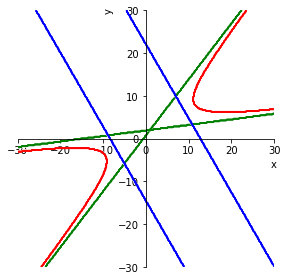

In [15]:
a = 12
b = 5

x0 = 1
y0 = 2

k1 = (b + a * 1/3**(S.Half)) / (a - b * 1/3**(S.Half))
k2 = (-b + a * 1/3**(S.Half)) / (a + b * 1/3**(S.Half))
c = Hyp1.focus_distance

dict_free = {str(a): a for a in eq2.free_symbols}
x = dict_free['x']
y = dict_free['y']

asymp1 = Eq(y, y0 + k1*(x - x0))
asymp2 = Eq(y, y0 + k2*(x - x0))
direct1 = Eq(y, y0 - 3**(S.Half)*(x - x0) + a**2/c * (1 + 3**(S.Half))**(S.Half))
direct2 = Eq(y, y0 - 3**(S.Half)*(x - x0) - a**2/c * (1 + 3**(S.Half))**(S.Half))

p = plot_implicit(eq2, (dict_free['x'], -30, 30), (dict_free['y'], -30, 30),
 line_color='r', aspect_ratio=(1, 1), show=False, adaptive=False)

p.extend(plot_implicit(asymp1, (x, -30, 30), (y, -30, 30), line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(asymp2, (x, -30, 30), (y, -30, 30), line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(direct1, (x, -30, 30), (y, -30, 30), line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(direct2, (x, -30, 30), (y, -30, 30), line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))

p.show()

###  Индивидуальное задание
Определить гиперболу с центром в точке $O (-1, 3)$, полуосями $a = 4$ и $b = 3$.  Вывести на экран эксцентриситет, фокусное расстояние, фокусы (с координатами), periapsis, уравнение гиперболы, уравнения асимптот и директрис. 

Изобразить гиперболу, повернутую на $\alpha =\pi / 4$ градусов против часовой стрелки относительно ее центра, соответствующие асимптоты и директрисы. Вывести на экран уравнения повернутой гиперболы, соответствующих асимптот и директрис.


'eccentricity'

5/4

'periapsis'

1

'focus_distance'

5

'foci'

(Point2D(-6, 3), Point2D(4, 3))

'equation'

(x/4 + 1/4)**2 - (y/3 - 1)**2 - 1

'asymptotes:'

Eq(y, 3*x/4 + 15/4)

Eq(y, 9/4 - 3*x/4)

'directrixes:'

Eq(x, 11/5)

Eq(x, -21/5)

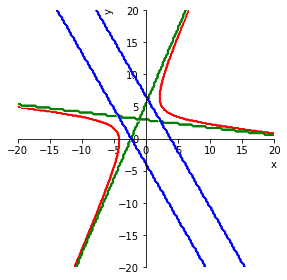

Eq(3*(x + sqrt(3)*(y - 3)/3 + 1)**2/64 - (y - sqrt(3)*(x + 1)/3 - 3)**2/12, 1)

'asymptotes:'

Eq(y, (4*sqrt(3)/3 + 3)*(x + 1)/(4 - sqrt(3)) + 3)

Eq(y, (-3 + 4*sqrt(3)/3)*(x + 1)/(sqrt(3) + 4) + 3)

'directrixes:'

Eq(y, -sqrt(3)*(x + 1) + 3 + 16*sqrt(1 + sqrt(3))/5)

Eq(y, -sqrt(3)*(x + 1) - 16*sqrt(1 + sqrt(3))/5 + 3)

In [17]:
a = 4
b = 3

x0 = -1
y0 = 3

k1 = (b + a * 1/3**(S.Half)) / (a - b * 1/3**(S.Half))
k2 = (-b + a * 1/3**(S.Half)) / (a + b * 1/3**(S.Half))

Hyp3 = Hyperbola(Point(x0, y0), hradius=a, vradius=b)

c = Hyp3.focus_distance

props = {'eccentricity': Hyp3.eccentricity, 'periapsis': Hyp3.periapsis,
 'focus_distance': Hyp3.focus_distance, 'foci': Hyp3.foci, 'equation': Hyp3.equation()}

for key in props.keys():
  display(key, props[key])

display('asymptotes:',*Hyp3.asymptote(equation = True))
display('directrixes:',*Hyp3.directrix(equation = True))

eq3 = Hyp3.equation(_slope=1/3**(S.Half), equation=True)

dict_free = {str(a): a for a in eq3.free_symbols}
x = dict_free['x']
y = dict_free['y']

asymp1 = Eq(y, y0 + k1*(x - x0))
asymp2 = Eq(y, y0 + k2*(x - x0))
direct1 = Eq(y, y0 - 3**(S.Half)*(x - x0) + a**2/c * (1 + 3**(S.Half))**(S.Half))
direct2 = Eq(y, y0 - 3**(S.Half)*(x - x0) - a**2/c * (1 + 3**(S.Half))**(S.Half))

p = plot_implicit(eq3, (dict_free['x'], -20, 20), (dict_free['y'], -20, 20), line_color='r', aspect_ratio=(1, 1), show=False, adaptive=False)

p.extend(plot_implicit(asymp1, (x, -40, 40), (y, -40, 40), line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(asymp2, (x, -40, 40), (y, -40, 40), line_color='g', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(direct1, (x, -40, 40), (y, -40, 40), line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))
p.extend(plot_implicit(direct2, (x, -40, 40), (y, -40, 40), line_color='b', aspect_ratio=(1, 1), show=False, adaptive=False))

p.show()

display(eq3)
display('asymptotes:', asymp1, asymp2)
display('directrixes:', direct1, direct2)